
# **Welcome to the eWaterCycle expirement notebook**

This notebook was generated by the eWaterCycle experiment launcher.

We will use GRDC data for comparison between the model simulation and the observations.

In this example notebook we run a hydrology model using [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi), but you can also choose to run your own model, WFLOW or Walrus.


In [44]:
%matplotlib inline  
import datetime
import os
import time
from datetime import datetime, timedelta

import cftime
import hydrostats.visual as hv
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

from bokeh.plotting import figure, output_notebook, show
from ewatercycle.parametersetdb import build_from_urls
from grpc4bmi.bmi_client_docker import BmiClientDocker


## **Setting the input and output configuration**

In [3]:
parameter_set = build_from_urls(
    config_format='ini', config_url='https://raw.githubusercontent.com/UU-Hydro/PCR-GLOBWB_input_example/master/RhineMeuse30min/ini_and_batch_files/rapid/setup_natural_test.ini',
    datafiles_format='svn', datafiles_url='https://github.com/UU-Hydro/PCR-GLOBWB_input_example/trunk/RhineMeuse30min',
)
parameter_set.save_datafiles('./input')

The model inside a BMI Docker container expects the datafiles in the /data/input directory,
the config file must be adjusted to that. 
**Uncomment** the block of the model that you are using:

*Please note that creating the input/output folders should be done only once.*

 - For **PCR-GLOBWB** model the input and output directory must be set with:

In [4]:
parameter_set.config['globalOptions']['inputDir'] = '/data/input'
parameter_set.config['globalOptions']['outputDir'] = '/data/output'

- For **wflow** model the config file must be set with: 

In [5]:
#parameter_set.config['model']['configfile'] = '/data/input/wflow_sbm.ini'
#replace config.cfg in the next cells with wflow_sbm.ini

- For **Walrus** model the data file must be set with

In [6]:
#import os; parameter_set.config['data'] = '/data/input/' + os.listdir('input')[0]

Then it can be saved to the config file:

In [7]:
parameter_set.save_config('config.cfg')

## **Run docker container that contains model**

In this example we use pcrglob, the model is loaded and initialized according to the configuration file we created in the previous section.

In [8]:
# Startup model
model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:latest', image_port=55555,
                        input_dir="./input",
                        output_dir="./output")
model.initialize('config.cfg')

We gather some information about the way the model handles time as we will need this to evolve the model:

In [24]:
tstart = int(model.get_start_time())
tend = int(model.get_end_time())
tstep = int(model.get_time_step())
tunit = model.get_time_units()
tstep_nmbr = (tend - tstart)/tstep 

print('model time step:', tstep)
print('model time unit:', tunit)
print('model time start:', tstart)
print('model time end:', tend)
print('nr of steps:', tstep_nmbr)

model time step: 1
model time unit: days since 1901-01-01
model time start: 36525
model time end: 40176
nr of steps: 3651.0


### Evolve the model and capture variable discharge

In [11]:
variable = 'discharge'
index_of_variable = np.array([144])
variable_overtime = []

In [ ]:
while model.get_current_time() < tend:
    model.update()
    value_at_pixel = model.get_value_at_indices(variable, index_of_variable)[0]
    variable_overtime.append((model.get_current_time(), value_at_pixel))

### Plot the variable at the current time as a function of lon/lat

Get the variable values at the current time, coordinates and other useful information for this plot. Since the model just ran until `tend`, this the current time. 

In [30]:
vals = model.get_value(variable)
unit = model.get_var_units(variable)
shape = model.get_grid_shape(model.get_var_grid(variable))
lon = model.get_grid_x(0)
lat = model.get_grid_y(0)
current_date = cftime.num2date(model.get_current_time(),tunit).date()

Reshape the one dimensional list of values to a two dimensional array for plotting and make the plot

[]

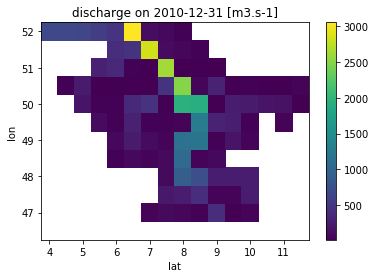

In [43]:
vals_array = np.reshape(ma.masked_where(vals == np.nan, vals), shape)
plt.title(r'{} on {} [{}]'.format(variable,current_date,unit))
plt.pcolormesh(lat,lon,vals_array)
plt.colorbar()
plt.xlabel('lat')
plt.ylabel('lon')
plt.plot()

## **Compare model with observations:**

### GRDC data:

User should provide the GRDC station id, pixel and the variable.

### Adjust the start/end time of your model to GRDC data.
Each modeler will have to adjust to his/her own model.

Here we adjust to pcrglob.

In [61]:
dstart = cftime.num2date(tstart, tunit).date()
dend = cftime.num2date(tend, tunit).date()
dlist = [cftime.num2date(d[0], tunit).date() for d in variable_overtime]

In [55]:
# Plot variable {0} at index {1} for each time step
output_notebook()
p = figure(plot_width=800, plot_height=400, x_axis_type="datetime")
p.yaxis.axis_label = variable + '[' + unit + ']'
p.line(date_list, [d[1] for d in variable_overtime] , line_width=2)
show(p)

Loading BokehJS ...

In [63]:
# Convert the pcrglob data into dataframe format (required for hydrostat)
Variable_DF = pd.DataFrame(variable_overtime, columns=["sim_time", "simulation"])
Variable_DF.index = dlist
#print(Variable_DF)

### Import GRDC data using GRDC station id, pixel and varaible

In [59]:
def dataframe_from_stationId(grdc_folder, station_id):
    ''' Search the grdc_folder for a file with name <station_id>.day,
    skip the header rows and return the dates and discharges in a dataframe'''
    
    filename = str(station_id) + "_Q_Day.Cmd"
    grdc_file = os.path.join(grdc_folder, filename)

    grdc_data = pd.read_csv(grdc_file, skiprows=40, delimiter=';')
    
    
    
    grdc_data = grdc_data.rename(columns={grdc_data.columns[0]: 'date', grdc_data.columns[1]:'empty', grdc_data.columns[2]: 'discharge'})
    
    grdc_data = grdc_data.reset_index().set_index(pd.DatetimeIndex(grdc_data['date']))
    grdc_data = grdc_data[['date', 'discharge']]
    
    return grdc_data

### In this example we currently use non-public data (!)

In [64]:
# Import GRDC station data, set index
obs = dataframe_from_stationId('./data_erase/', 6435060)
# choose the correct time range to fit the model
#obs_timerange = obs.loc[str(tstart):str(tend)]
obs_timerange = obs.loc[dstart:dend]

### Select timeseries based on GRDC station id and pixel

In [65]:
Variable_DF["obs"] = obs_timerange["discharge"]
print(Variable_DF)

            sim_time   simulation     obs
2001-01-01   36525.0     1.398860  2125.0
2001-01-02   36526.0    26.308891  2028.0
2001-01-03   36527.0   186.483063  1961.0
2001-01-04   36528.0   515.902222  2015.0
2001-01-05   36529.0  1450.983276  2222.0
2001-01-06   36530.0  2829.645508  2626.0
2001-01-07   36531.0  2177.182129  3522.0
2001-01-08   36532.0  1701.762451  4523.0
2001-01-09   36533.0  1611.242065  5008.0
2001-01-10   36534.0  1611.164429  4907.0
2001-01-11   36535.0  1580.624390  4518.0
2001-01-12   36536.0  1527.283936  4095.0
2001-01-13   36537.0  1476.182251  3792.0
2001-01-14   36538.0  1401.665405  3538.0
2001-01-15   36539.0  1337.403931  3253.0
2001-01-16   36540.0  1298.621948  2994.0
2001-01-17   36541.0  1268.675415  2731.0
2001-01-18   36542.0  1244.255249  2530.0
2001-01-19   36543.0  1222.499023  2368.0
2001-01-20   36544.0  1200.071045  2255.0
2001-01-21   36545.0  1290.306030  2154.0
2001-01-22   36546.0  1463.128906  2064.0
2001-01-23   36547.0  1563.523315 

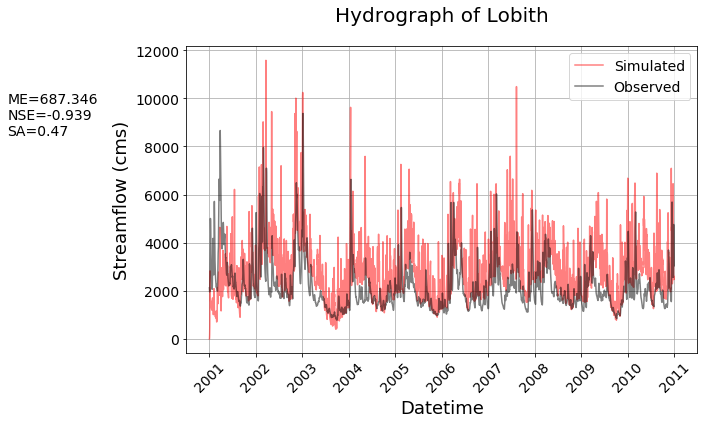

In [66]:
#Plot hydrograph for simulated and observed values and calculate statistics

hv.plot(Variable_DF[['simulation', 'obs']],
      title='Hydrograph of Lobith',
      linestyles=['r-', 'k-'],
      legend=('Simulated', 'Observed'),
      labels=['Datetime', 'Streamflow (cms)'],
      metrics=['ME', 'NSE', 'SA'],
      grid=True)
plt.show()